# Visualize Partial Prediction Alignments

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
sys.path.append("..")

from src.eval.SampleResult import SampleResult

## Parameters

In [17]:
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"

ALIGNMENT_SEQUENCE = "baseline"
TEMPORAL_ALIGNMENT_TOLERANCE = 0.1
ALIGNMENT_WORD_NORMALIZATION = True

In [38]:
SAMPLE_ID = "1221-135767-0000"
SAMPLE_ID = "5639-40744-0000"

window_start = 140
window_length = 30

DRAW_CONFIRMED_ALIGNMENTS = False

### Draw Function

In [39]:
sample = SampleResult.load_by_id(RESULT_DIR, SAMPLE_ID)
sample.build_alignments(normalize_words=ALIGNMENT_WORD_NORMALIZATION,
                        align_to=ALIGNMENT_SEQUENCE,
                        temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE)

In [40]:
def draw():
    window_end = window_start + window_length

    words = sample._alignment_sequence[window_start:window_end]

    window_start_t = words[0].start
    window_end_t = words[-1].end

    # Filter predictions and keep original indices
    indexed_predictions = [
        (i, p) for i, p in enumerate(sample.partials)
        if window_start_t <= p.window[1] and (p.observation_time <= window_end_t or p.window[1] <= window_end_t)
    ]
    indexed_predictions = indexed_predictions[::-1]  # Reverse for display

    # Final word mapping (global indices to x/y coordinates)
    final_word_positions = {
        i: {
            "x": (word.start + word.end) / 2,
            "y": len(indexed_predictions) + 0.25  # fixed y for final row
        }
        for i, word in enumerate(sample._alignment_sequence)
    }

    # Determine max observation time for x-axis limit
    max_obs_time = max(window_end_t, max(p.observation_time for _, p in indexed_predictions))

    fig, ax = plt.subplots(figsize=(30, 8))

    for row_index, (original_index, partial) in enumerate(indexed_predictions):
        win_start, win_end = partial.window
        obs_time = partial.observation_time

        # Green prediction window
        ax.add_patch(Rectangle((win_start, row_index), win_end - win_start, 1, color="green", alpha=0.3))

        marker_width = 0.01
        ax.add_patch(Rectangle((win_end - marker_width / 2, row_index), marker_width, 1, color="green", alpha=0.9))

        # Red delay box
        if obs_time > win_end:
            delay = obs_time - win_end
            ax.add_patch(Rectangle(
                (win_end, row_index), delay, 1,
                color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
            ))
            # Delay label
            ax.text(win_end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

        ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

        # Word boxes
        for word_index, word in enumerate(partial.result):
            if window_start_t <= word.start <= window_end_t:
                ax.add_patch(Rectangle(
                    (word.start, row_index + 0.25), word.end - word.start, 0.5,
                    edgecolor="darkgreen", facecolor="none", linewidth=1
                ))
                ax.text((word.start + word.end) / 2, row_index + 0.5, word.word,
                        ha="center", va="center", fontsize=9, color="darkgreen")
                
                # Draw alignment line
                wa = None
                accepted = False
                if DRAW_CONFIRMED_ALIGNMENTS:
                    for _wa in sample.alignments[original_index].confirmed_alignments:
                        if _wa.partial_word_index == word_index:
                            wa = _wa
                            break
                for _wa in sample.alignments[original_index].accepted_alignments:
                    if _wa.partial_word_index == word_index:
                        wa = _wa
                        accepted = True
                        break
                if wa is None and not DRAW_CONFIRMED_ALIGNMENTS:
                    for _wa in sample.alignments[original_index].potential_alignments:
                        if _wa.partial_word_index == word_index:
                            wa = _wa
                            break
                if wa is not None:
                    if wa.final_word_index in final_word_positions:
                        x0 = (word.start + word.end) / 2
                        y0 = row_index + 0.75
                        x1 = final_word_positions[wa.final_word_index]["x"]
                        y1 = final_word_positions[wa.final_word_index]["y"]
                        color = "blue" if DRAW_CONFIRMED_ALIGNMENTS else "lightgreen" if accepted else "orange"
                        ax.plot([x0, x1], [y0, y1], color=color, linestyle="dashed", linewidth=1)
                else:
                    ax.plot((word.start + word.end) / 2, row_index + 0.85, "o", color="red", markersize=3, alpha=0.5)
                

    # Draw top word layer (blue)
    word_y = len(indexed_predictions)
    for i, word in enumerate(words):
        start = word.start
        end = word.end
        ax.add_patch(Rectangle((start, word_y), end - start, 1, color="blue", alpha=0.5))
        ax.text((start + end) / 2, word_y + 0.5, word.word, ha="center", va="center", fontsize=10)
        ax.text((start + end) / 2, word_y + 1.3, f"{window_start + i}", ha="center", va="center", fontsize=10, color="black")
        ax.axvline(start, color="black", linestyle="--", linewidth=0.5, alpha=0.5)
        ax.axvline(end, color="black", linestyle="--", linewidth=0.5, alpha=0.5)

    window_end_t = max_obs_time + 0.5

    # Axes setup
    ax.set_xlim(window_start_t, window_end_t)
    ax.set_ylim(0, word_y + 2)
    ax.set_yticks([i + 0.5 for i in range(len(indexed_predictions))])
    ax.set_yticklabels([str(idx) for idx, _ in indexed_predictions])
    ax.xaxis.tick_top()

### Result

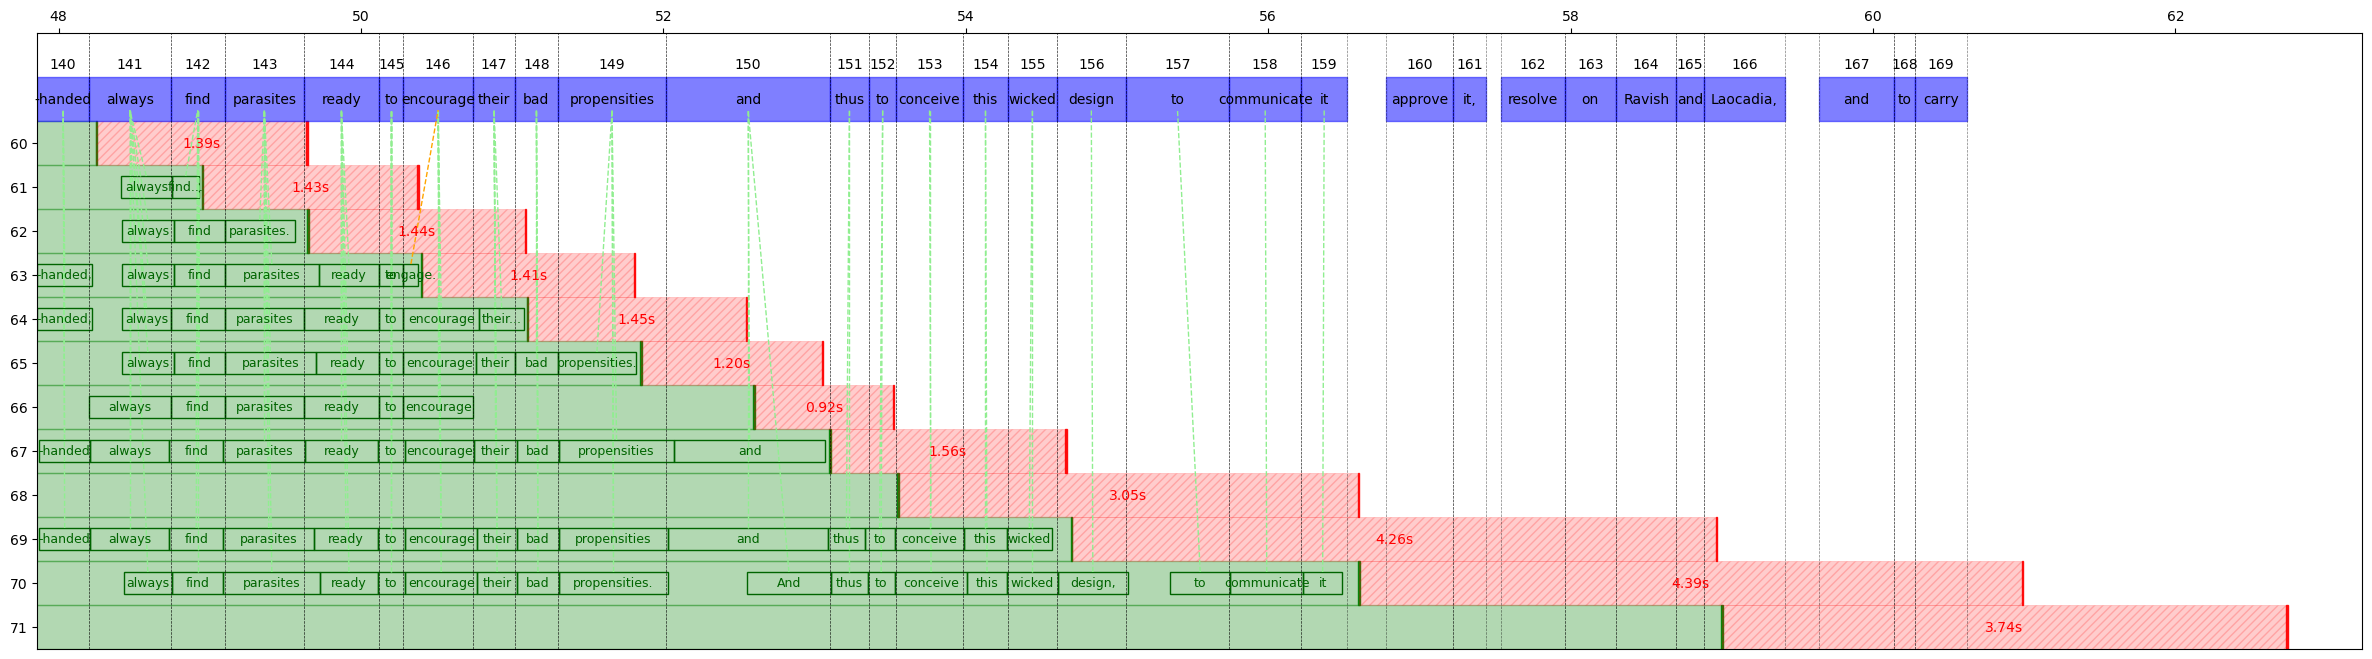

In [41]:
draw()

In [53]:
for p in sample.partials:
    print(f"Prediction for time window {p.window} with length {p.window[1] - p.window[0]}s")

Prediction for time window (0.0, 1.0) with length 1.0s
Prediction for time window (0.0, 2.0) with length 2.0s
Prediction for time window (0.0, 3.0) with length 3.0s
Prediction for time window (0.0, 4.0) with length 4.0s
Prediction for time window (0.0, 5.0) with length 5.0s
Prediction for time window (0.0, 6.0) with length 6.0s
Prediction for time window (0.0, 7.0) with length 7.0s
Prediction for time window (0.0, 8.0) with length 8.0s
Prediction for time window (0.0, 9.0) with length 9.0s
Prediction for time window (0.0, 10.0) with length 10.0s
Prediction for time window (0.0, 11.0) with length 11.0s
Prediction for time window (0.0, 12.0) with length 12.0s
Prediction for time window (0.0, 12.05) with length 12.05s
Prediction for time window (0.0, 14.1) with length 14.1s
Prediction for time window (0.0, 14.55) with length 14.55s
Prediction for time window (0.0, 15.2) with length 15.2s
Prediction for time window (0.9, 15.95) with length 15.049999999999999s
Prediction for time window (0.